##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [ ]:
!pip install -U -q tensorflow==2.17.0  tensorflow_datasets

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import itertools
import librosa

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
print(os.getcwd())

tvd_2024_reconocimiento_de_comandos_de_voz_path = kagglehub.competition_download('tvd-2024-reconocimiento-de-comandos-de-voz')

print('Data source import complete.')

/content
Data source import complete.


## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [ ]:
DATASET_PATH = '/root/.cache/kagglehub/competitions/tvd-2024-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command.

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['on' 'down' 'cat' 'three' 'up' 'no' 'sheila' 'stop' 'tree' 'zero' 'six'
 'four' 'seven' 'one' 'right' 'off' 'marvin' 'five' 'dog' 'two' 'go'
 'left' 'wow' 'bird' 'house' 'happy' 'nine' '_background_noise_' 'eight'
 'bed' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

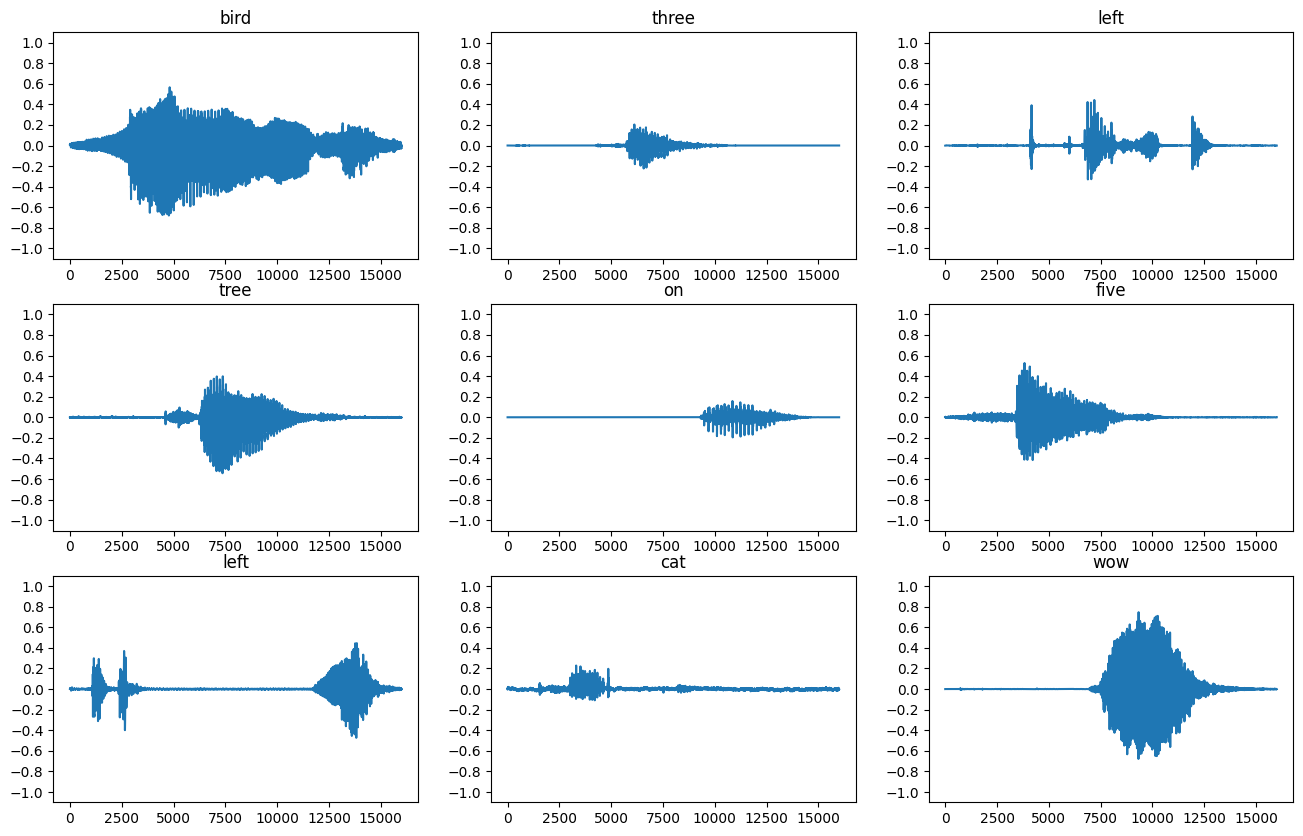

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

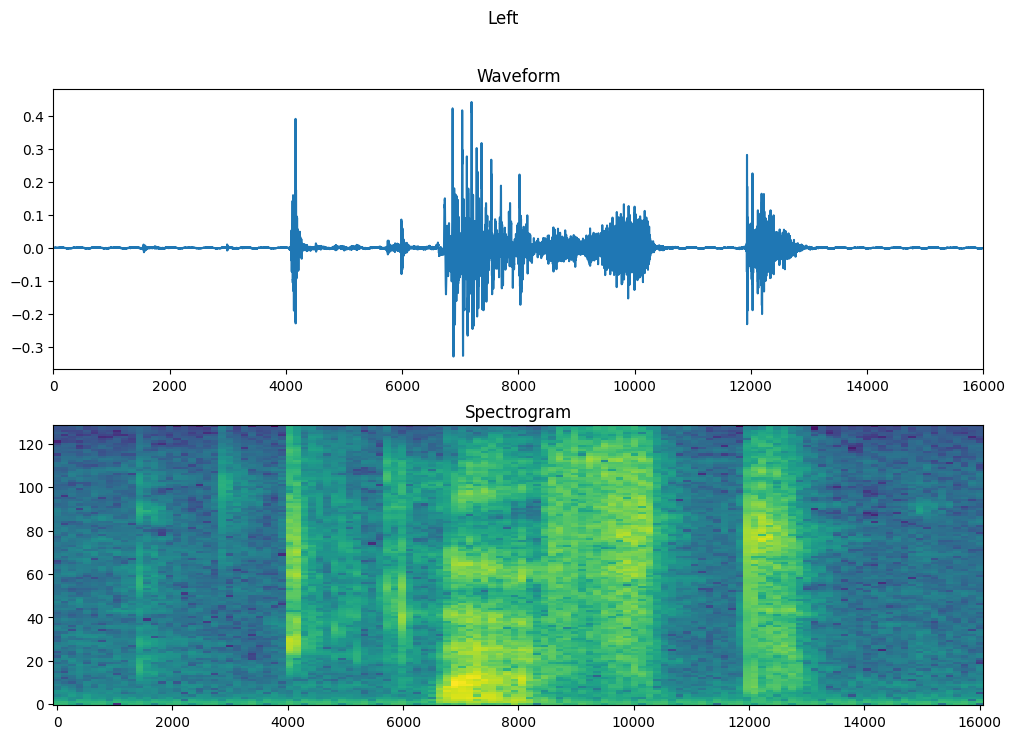

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

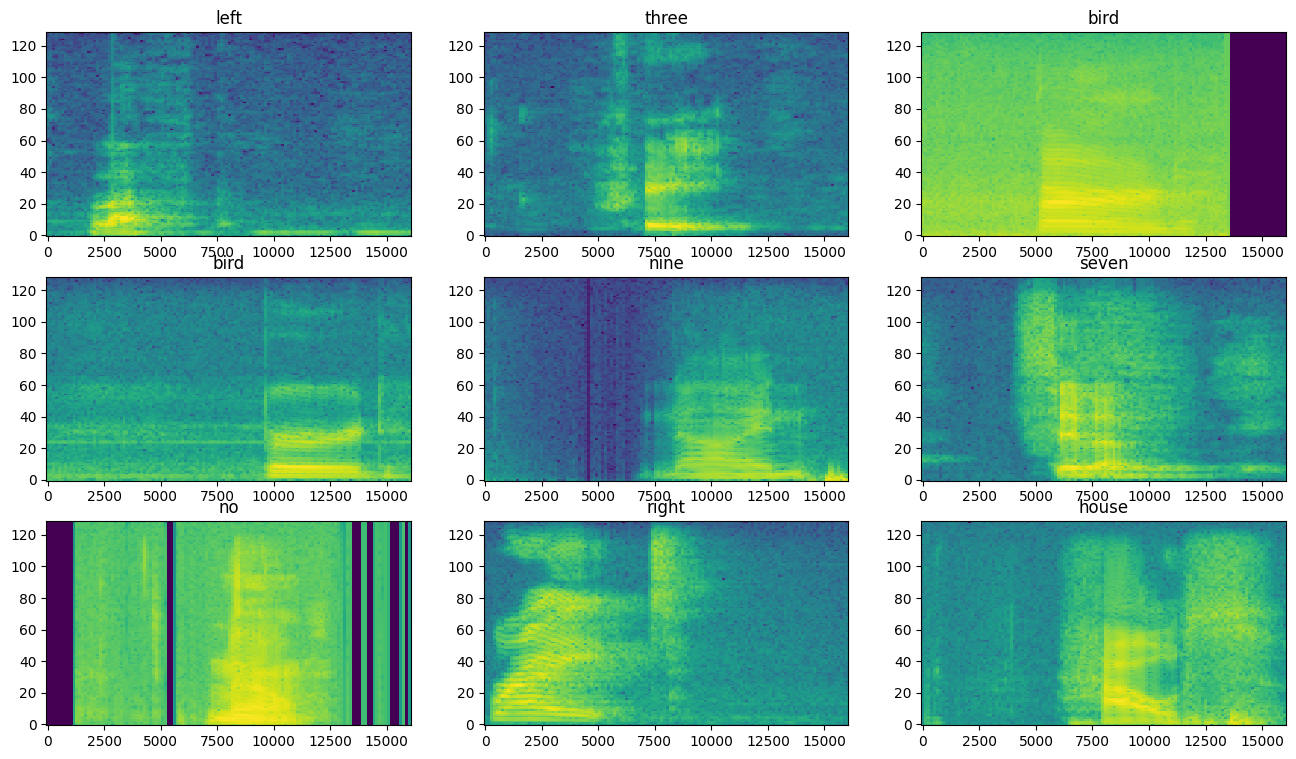

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           2,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 5
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.2555 - loss: 2.6921 - val_accuracy: 0.4906 - val_loss: 1.8066
Epoch 2/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5286 - loss: 1.6617 - val_accuracy: 0.5852 - val_loss: 1.4599
Epoch 3/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6234 - loss: 1.3099 - val_accuracy: 0.6318 - val_loss: 1.2999
Epoch 4/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6796 - loss: 1.1209 - val_accuracy: 0.6643 - val_loss: 1.1904
Epoch 5/5
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7208 - loss: 0.9823 - val_accuracy: 0.6925 - val_loss: 1.1236


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

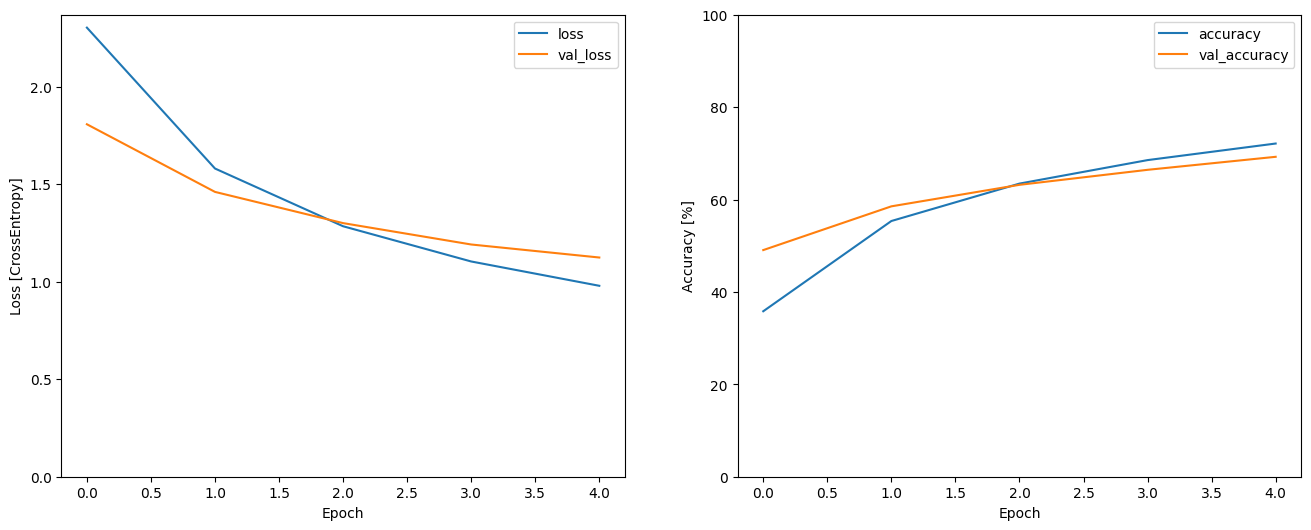

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6929 - loss: 1.1437


{'accuracy': 0.6971146464347839, 'loss': 1.1327093839645386}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

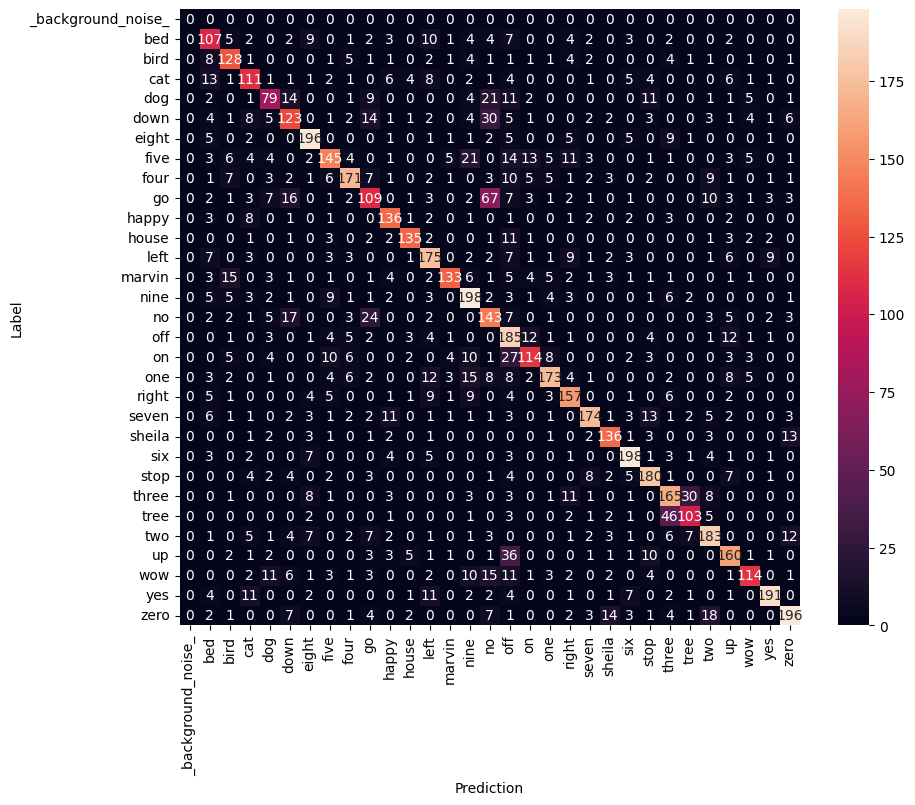

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**.

In [ ]:
l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)

# Definició dels models

In [ ]:
EPOCHS = 50
num_labels = len(label_names)

In [ ]:
input_shape = example_spectrograms.shape[1:]
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [ ]:
class Experiment_Models():
    def __init__(self, experiments, epochs):
        self.exp = experiments
        self.results = {}
        self.EPOCHS = epochs

    def run_exp(self, build_model, train_spectrogram_ds, val_spectrogram_ds):
        for exp in self.exp:
            model = build_model(exp)
            self.results[exp] = self._run_model(model, train_spectrogram_ds, val_spectrogram_ds)

    def _run_model(self, model, train_spectrogram_ds, val_spectrogram_ds):
        start_time = time.time()
        history = model.fit(
            train_spectrogram_ds,
            validation_data=val_spectrogram_ds,
            epochs=self.EPOCHS,
            callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
        )
        elapsed_time = time.time() - start_time
        return {'model': model, 'history': history.history,'time': elapsed_time}

    def training_plot(self, separate):
        if not separate:
            for exp in self.exp:
                plt.plot(self.results[exp]['history']['val_accuracy'], label=f'{exp} (val)')
                plt.plot(self.results[exp]['history']['accuracy'], label=f'{exp} (train)')

            plt.title('Precisión por Arquitectura')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.legend()
            plt.show()
        else:
            plt.figure(figsize=(16, 6))

            plt.subplot(1, 2, 1)
            for exp in self.exp:
                plt.plot(self.results[exp]['history']['accuracy'], label=f'{exp}')
            plt.title('Precisión por Arquitectura (Train)')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.legend(fontsize=8)

            plt.subplot(1, 2, 2)
            for exp in self.exp:
                plt.plot(self.results[exp]['history']['val_accuracy'], label=f'{exp}')
            plt.title('Precisión por Arquitectura (Validation)')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.legend(fontsize=8)

            # Mostrar la figura completa
            plt.tight_layout()  # Ajustar diseño para evitar solapamiento
            plt.show()

    def exec_time(self):
        for exp in self.exp:
            print(f"{exp} - Tiempo total de entrenamiento: {self.results[exp]['time']:.2f} segundos")

    def model_summary(self):
        for exp in self.exp:
            print(f"MODELO: {exp}")
            self.results[exp]['model'].summary()
            print("___________________________________________________________________________________________________")

    def table_results(self):
        return pd.DataFrame({str(exp): [self.results[exp]['history']["accuracy"][-1], \
                    self.results[exp]['history']["val_accuracy"][-1]] for exp in self.exp}, index=['train', 'val'])

    def test_inference(self, model, test_spectrogram_ds, label_names):
        model.evaluate(test_spectrogram_ds, return_dict=True)
        self.y_pred = model.predict(test_spectrogram_ds)
        self.y_pred = tf.argmax(self.y_pred, axis=1)
        y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
        confusion_mtx = tf.math.confusion_matrix(y_true, self.y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx,
                    xticklabels=label_names,
                    yticklabels=label_names,
                    annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.show()

    def save_submission(self, submission_name):
        l = [[i,j] for i,j in zip(list(range(1,len(self.y_pred)+1)), self.y_pred.numpy().tolist())]
        df = pd.DataFrame(l, columns=['ID','labels'])
        df.to_csv(submission_name, index=False)

## Ajustació de nombres d'èpoques

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 31)                  │           2,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2374 - loss: 2.7404 - val_accuracy: 0.4819 - val_loss: 1.8283
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5370 - loss: 1.6450 - val_accuracy: 0.6038 - val_loss: 1.4319
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6385 - loss: 1.2825 - val_accuracy: 0.6559 - val_loss: 1.2718
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6927 - loss: 1.0845 - val_accuracy: 0.6776 - val_loss: 1.1506
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7338 - loss: 0.9323 - val_accuracy: 0.6937 - val_loss: 1.1106
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7552 - loss: 0.8506 - val_accuracy: 0.7109 - val_loss: 1.1235
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7762 - loss: 0.7767 - val_accuracy: 0.7160 - val_loss: 1.0804
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7906 - loss: 0.7181 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy [%]')

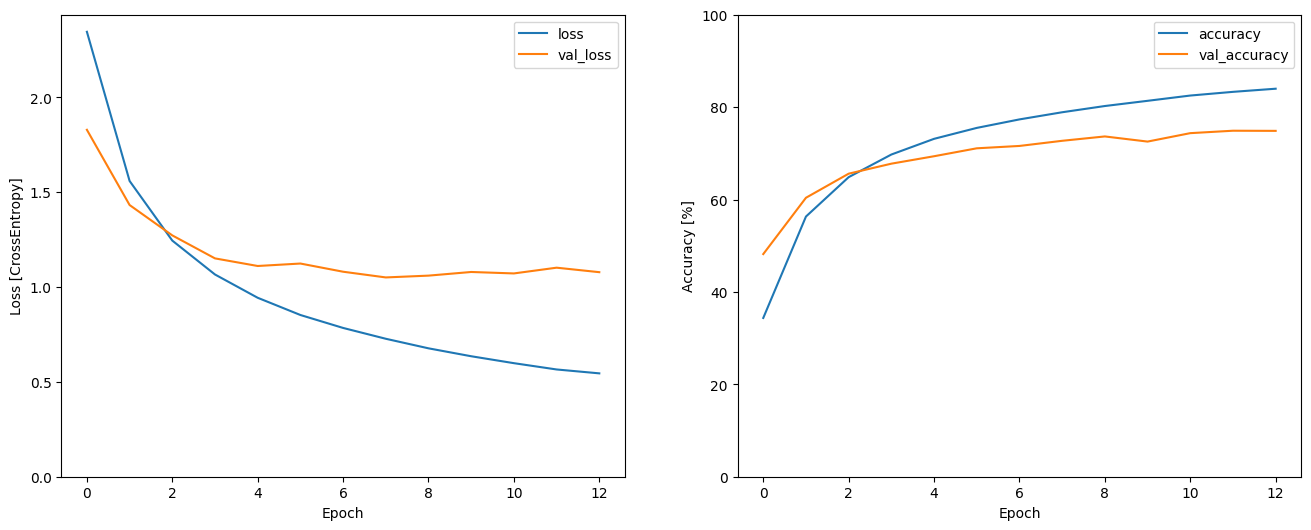

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7456 - loss: 1.0921


{'accuracy': 0.7514272332191467, 'loss': 1.0635710954666138}

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


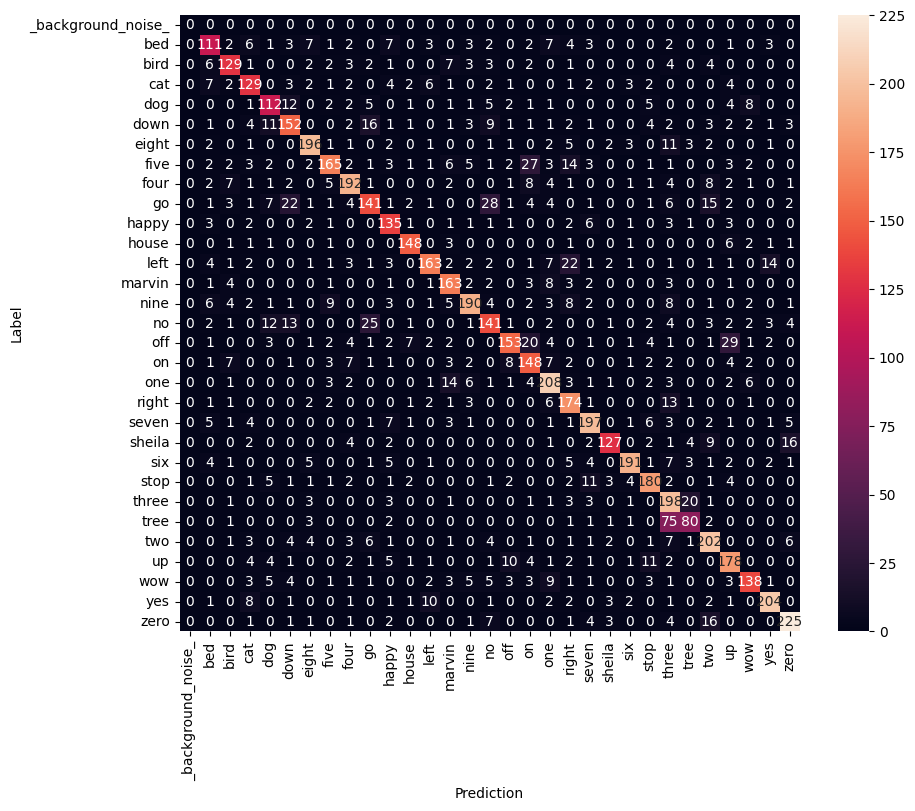

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission_more_epochs.csv', index=False)

## RNN

In [ ]:
def build_model_rnn(architecture):
    architecture = architecture.split('-')
    architecture, num_layers, bidirectional = architecture[0], int(architecture[1]), architecture[2] == 'Bid'

    # Inicialización del modelo
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        layers.Normalization(),
        # Reshape para que la forma sea compatible con capas recurrentes
        layers.Reshape((32, 32 * 1)), # Added this line to reshape
    ])

    if architecture == 'lstm':
        units = 128  # Tamaño de las unidades, se puede ajustar
        for i in range(num_layers):
            if bidirectional:
                # Usamos Bidirectional si es necesario
                if i == num_layers - 1:
                    model.add(layers.Bidirectional(layers.LSTM(units)))
                else:
                    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True)))
            else:
                if i == num_layers - 1:
                    model.add(layers.LSTM(units))
                else:
                    model.add(layers.LSTM(units, return_sequences=True))

    elif architecture == 'gru':
        units = 128  # Tamaño de las unidades, se puede ajustar
        for i in range(num_layers):
            if bidirectional:
                # Usamos Bidirectional si es necesario
                if i == num_layers - 1:
                    model.add(layers.Bidirectional(layers.GRU(units)))
                else:
                    model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True)))
            else:
                if i == num_layers - 1:
                    model.add(layers.GRU(units))
                else:
                    model.add(layers.GRU(units, return_sequences=True))

    # Capa final
    model.add(layers.Dropout(0.3))  # Dropout para regularización
    model.add(layers.Dense(256, activation='relu'))  # Capa densa intermedia
    model.add(layers.Dropout(0.3))  # Dropout para regularización
    model.add(layers.Dense(512, activation='relu'))  # Capa densa más grande
    model.add(layers.Dense(num_labels, activation='softmax'))  # Softmax para clasificación multiclase

    # Compilación del modelo
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [ ]:
exp_rnn = Experiment_Models(['lstm-5-Bid', 'lstm-7-Bid', 'lstm-5-NoBid', 'lstm-7-NoBid', 'gru-5-Bid', 'gru-7-Bid', 'gru-5-NoBid', 'gru-7-NoBid'], EPOCHS)
exp_rnn.run_exp(build_model_rnn, train_spectrogram_ds, val_spectrogram_ds)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.2840 - loss: 2.3735 - val_accuracy: 0.7143 - val_loss: 0.9563
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.7486 - loss: 0.8550 - val_accuracy: 0.8360 - val_loss: 0.5565
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.8360 - loss: 0.5698 - val_accuracy: 0.8549 - val_loss: 0.4919
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8716 - loss: 0.4513 - val_accuracy: 0.8776 - val_loss: 0.4134
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.8958 - loss: 0.3687 - val_accuracy: 0.8977 - val_loss: 0.3679
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9094 - loss: 0.3262 - val_accuracy: 0.9120 - val_loss: 0.3082
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.9243 - loss: 0.2678 - val_accuracy: 0.9129 - val_loss: 0.3065
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9312 - loss: 0.2439 - 

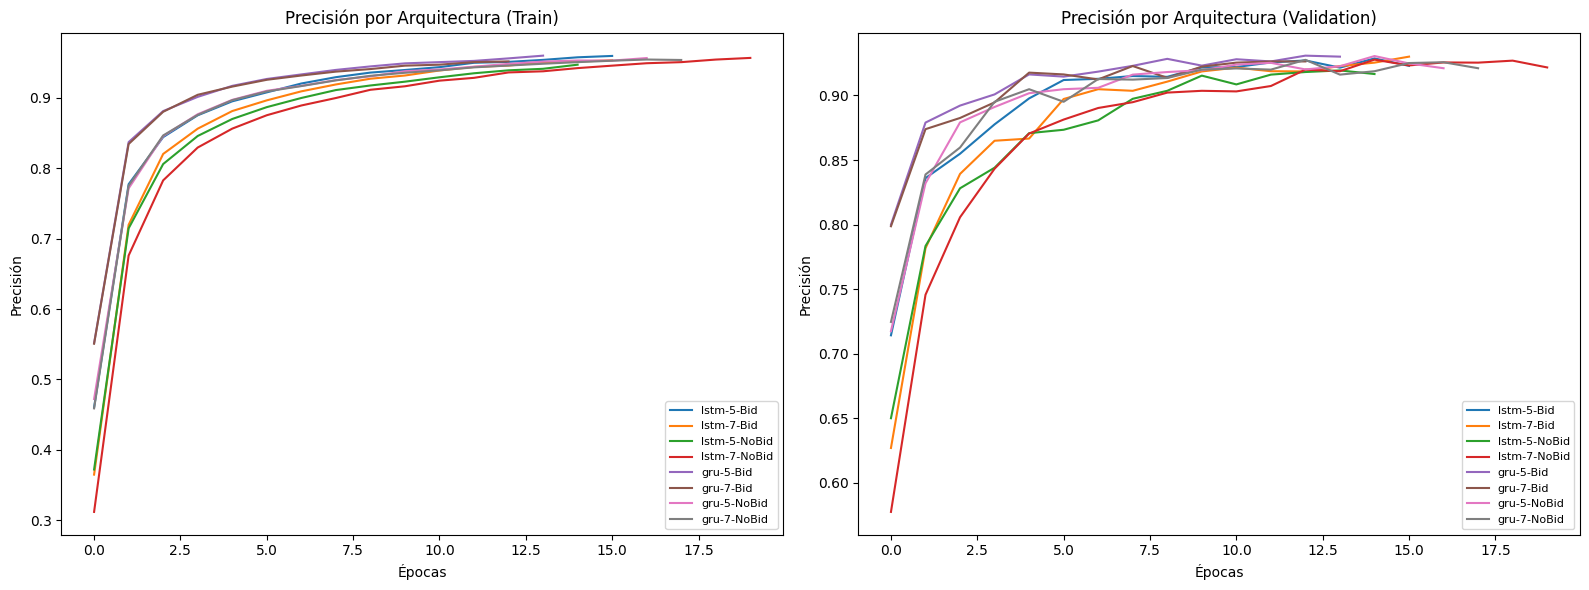

lstm-5-Bid - Tiempo total de entrenamiento: 533.99 segundos
lstm-7-Bid - Tiempo total de entrenamiento: 614.14 segundos
lstm-5-NoBid - Tiempo total de entrenamiento: 251.56 segundos
lstm-7-NoBid - Tiempo total de entrenamiento: 371.94 segundos
gru-5-Bid - Tiempo total de entrenamiento: 481.45 segundos
gru-7-Bid - Tiempo total de entrenamiento: 496.56 segundos
gru-5-NoBid - Tiempo total de entrenamiento: 288.53 segundos
gru-7-NoBid - Tiempo total de entrenamiento: 329.73 segundos


In [ ]:
exp_rnn.training_plot(True)
exp_rnn.exec_time()

In [ ]:
exp_rnn.model_summary()

MODELO: lstm-5-Bid


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,865,314 (22.37 MB)

 Trainable params: 1,955,103 (7.46 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,910,208 (14.92 MB)

___________________________________________________________________________________________________
MODELO: lstm-7-Bid


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32, 256)             │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 32, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,230,754 (31.40 MB)

 Trainable params: 2,743,583 (10.47 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 5,487,168 (20.93 MB)

___________________________________________________________________________________________________
MODELO: lstm-5-NoBid


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 32, 128)             │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,367,842 (9.03 MB)

 Trainable params: 789,279 (3.01 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,578,560 (6.02 MB)

___________________________________________________________________________________________________
MODELO: lstm-7-NoBid


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_3 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32, 128)             │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 32, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,157,346 (12.04 MB)

 Trainable params: 1,052,447 (4.01 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 2,104,896 (8.03 MB)

___________________________________________________________________________________________________
MODELO: gru-5-Bid


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_4 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 32, 256)             │         124,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,570,466 (17.43 MB)

 Trainable params: 1,523,487 (5.81 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,046,976 (11.62 MB)

___________________________________________________________________________________________________
MODELO: gru-7-Bid


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_5 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 32, 256)             │         124,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_19 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 32, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,349,154 (24.22 MB)

 Trainable params: 2,116,383 (8.07 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 4,232,768 (16.15 MB)

___________________________________________________________________________________________________
MODELO: gru-5-NoBid


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_6 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 32, 128)             │          62,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_16 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,917,026 (7.31 MB)

 Trainable params: 639,007 (2.44 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,278,016 (4.88 MB)

___________________________________________________________________________________________________
MODELO: gru-7-NoBid


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_7 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_7 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 32, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 32, 128)             │          62,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_18 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_19 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_20 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_21 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_22 (GRU)                         │ (None, 32, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_23 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,511,458 (9.58 MB)

 Trainable params: 837,151 (3.19 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,674,304 (6.39 MB)

___________________________________________________________________________________________________


In [ ]:
exp_rnn.table_results()

,lstm-5-Bid,lstm-7-Bid,lstm-5-NoBid,lstm-7-NoBid,gru-5-Bid,gru-7-Bid,gru-5-NoBid,gru-7-NoBid
train,0.959754,0.953536,0.947318,0.956935,0.960160,0.951952,0.956742,0.953999
val,0.922958,0.930074,0.916615,0.921720,0.930074,0.926361,0.921102,0.921102


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9283 - loss: 0.3273
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


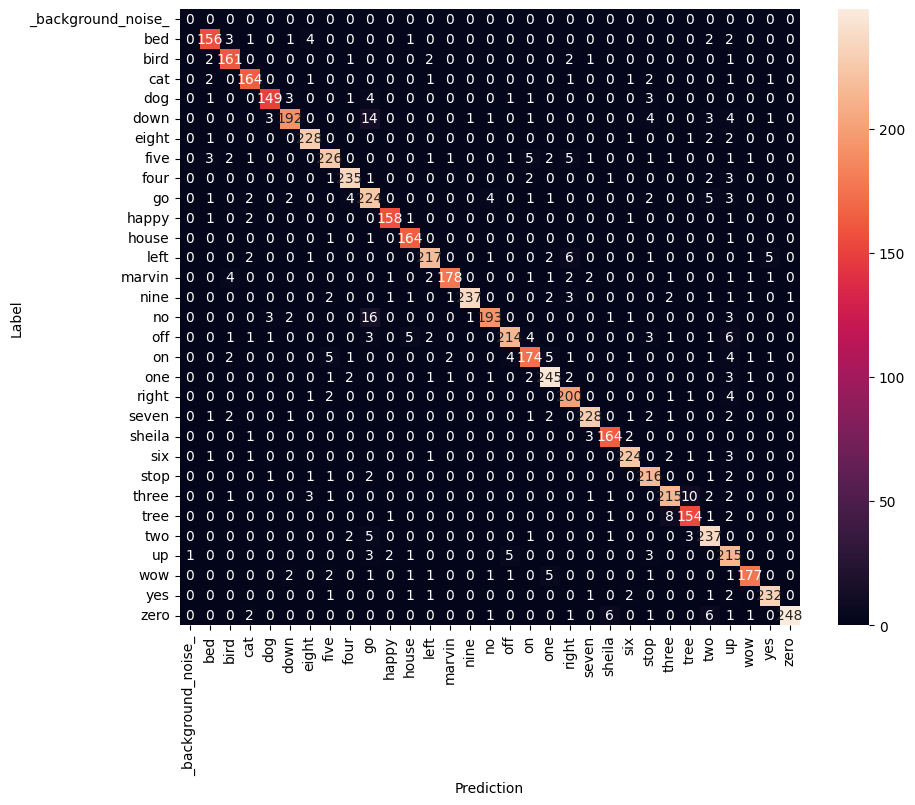

In [ ]:
best_rnn_model = exp_rnn.results['gru-5-Bid']['model']
exp_rnn.test_inference(best_rnn_model, test_spectrogram_ds, label_names)

In [ ]:
exp_rnn.save_submission('submission_rnn.csv')

## Convolucional

In [ ]:
# Función para construir diferentes arquitecturas
def build_model_conv(architecture='base'):
    if architecture == 'base':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Resizing(32, 32),
            layers.Normalization(),
            layers.Conv2D(32, 3, activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_labels)
        ])
    elif architecture == 'intermediate':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Resizing(32, 32),
            layers.Normalization(),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.Conv2D(32, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),
            layers.Conv2D(64, 3, activation='relu', padding='same'),
            layers.MaxPooling2D(),
            layers.Dropout(0.4),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_labels)
        ])
    elif architecture == 'advanced':
        model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsampling the input
        layers.Resizing(32, 32),
        # Normalization
        layers.Normalization(),

        # Bloque Conv1
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # Bloque Conv2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        # Bloque Conv3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),

        # Flatten y capas densas
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    return model

In [ ]:
exp_cnn = Experiment_Models(['base', 'intermediate', 'advanced'], EPOCHS)
exp_cnn.run_exp(build_model_conv, train_spectrogram_ds, val_spectrogram_ds)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - accuracy: 0.2552 - loss: 2.7258 - val_accuracy: 0.5141 - val_loss: 1.7553
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5643 - loss: 1.5702 - val_accuracy: 0.6115 - val_loss: 1.3952
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6601 - loss: 1.2347 - val_accuracy: 0.6714 - val_loss: 1.2013
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7178 - loss: 1.0185 - val_accuracy: 0.7031 - val_loss: 1.1040
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7465 - loss: 0.8995 - val_accuracy: 0.7146 - val_loss: 1.0657
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7774 - loss: 0.7897 - val_accuracy: 0.7307 - val_loss: 1.0135
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7940 - loss: 0.7234 - val_accuracy: 0.7369 - val_loss: 1.0014
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8088 - loss: 0.6703 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


810/810 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.2082 - loss: 2.7621 - val_accuracy: 0.7687 - val_loss: 0.7924
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6852 - loss: 1.0377 - val_accuracy: 0.8507 - val_loss: 0.5036
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7845 - loss: 0.7220 - val_accuracy: 0.8840 - val_loss: 0.3860
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8225 - loss: 0.6013 - val_accuracy: 0.8912 - val_loss: 0.3635
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8442 - loss: 0.5277 - val_accuracy: 0.9117 - val_loss: 0.2966
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8570 - loss: 0.4862 - val_accuracy: 0.9220 - val_loss: 0.2771
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8675 - loss: 0.4539 - val_accuracy: 0.9206 - val_loss: 0.2708
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8756 - loss: 0.4220 - val_accuracy: 0.9245 - 

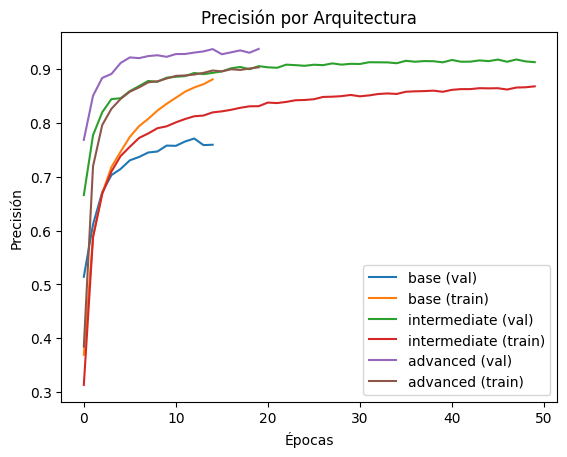

base - Tiempo total de entrenamiento: 107.17 segundos
intermediate - Tiempo total de entrenamiento: 265.80 segundos
advanced - Tiempo total de entrenamiento: 172.94 segundos


In [ ]:
exp_cnn.training_plot(False)
exp_cnn.exec_time()

In [ ]:
print(exp_cnn.model_summary())

MODELO: base


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_4 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │         460,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 31)                  │           2,015 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,389,602 (5.30 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 926,400 (3.53 MB)

___________________________________________________________________________________________________
MODELO: intermediate


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_5 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,669,442 (6.37 MB)

 Trainable params: 556,479 (2.12 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,112,960 (4.25 MB)

___________________________________________________________________________________________________
MODELO: advanced


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_6 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_6 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,456,834 (9.37 MB)

 Trainable params: 818,943 (3.12 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,637,888 (6.25 MB)

___________________________________________________________________________________________________
None


In [ ]:
exp_cnn.table_results()

,base,intermediate,advanced
train,0.881175,0.868236,0.903596
val,0.759592,0.913212,0.937809


102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9370 - loss: 0.2337
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


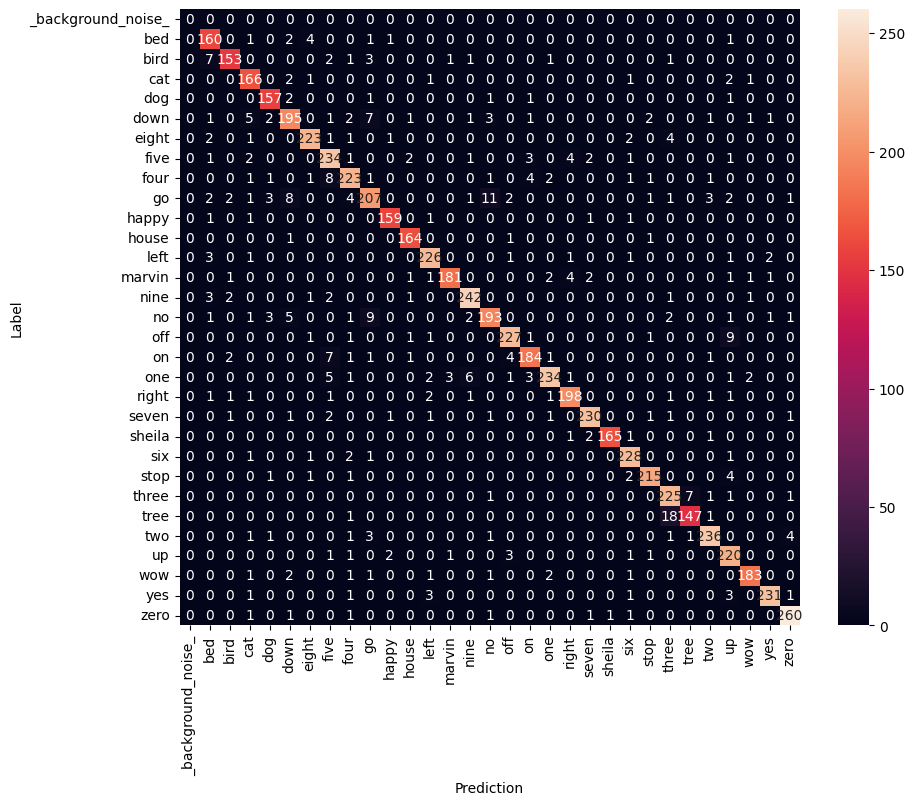

In [ ]:
best_cnn_model = exp_cnn.results['advanced']['model']
exp_cnn.test_inference(best_cnn_model, test_spectrogram_ds, label_names)

In [ ]:
exp_cnn.save_submission('submission_cnn.csv')

## Transformers

In [ ]:
# We provide some function you may find useful for your models

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [ ]:
def build_model_transformer(
    architecture
):
    embed_dim, num_heads, ff_dim, num_transformer_blocks = architecture[0], architecture[1], architecture[2], architecture[3]
    # Preprocesamiento invariable
     # Assuming your spectrogram is of size (32, 32, 1)
    patch_size = 4  # Example patch size
    num_patches = (32 // patch_size) * (32 // patch_size)  # Total number of patches

    preprocessing = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),  # Cambia tamaño del espectrograma a 32x32,
        layers.Normalization(),
        layers.Reshape((num_patches, patch_size * patch_size)),
        layers.Dense(embed_dim),  # Proyección al espacio latente
    ])

    # Bloques del Transformer como una lista
    transformer_blocks = [
        TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, rate=0.3)
        for _ in range(num_transformer_blocks)
    ]

    # Modelo principal
    model = models.Sequential([
        preprocessing,
        *transformer_blocks,  # Desempaquetar bloques del Transformer
        layers.GlobalAveragePooling1D(),  # Pooling global
        layers.Dropout(0.3),  # Regularización
        layers.Dense(256, activation="relu"),  # Capa oculta
        layers.Dropout(0.3),
        layers.Dense(num_labels, activation="softmax"),  # Salida
    ])

    # Compilación del modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )

    return model

In [ ]:
embed_dim_options = [64, 128]
num_heads_options = [4, 6]
ff_dim_options = [128]
num_transformer_blocks_options = [3, 5]

# Combinaciones de hiperparámetros
param_combinations = list(itertools.product(
    embed_dim_options,
    num_heads_options,
    ff_dim_options,
    num_transformer_blocks_options
))

exp_transf = Experiment_Models(param_combinations, EPOCHS)
exp_transf.run_exp(build_model_transformer, train_spectrogram_ds, val_spectrogram_ds)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - accuracy: 0.2140 - loss: 2.6592 - val_accuracy: 0.5620 - val_loss: 1.4344
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5520 - loss: 1.4827 - val_accuracy: 0.6700 - val_loss: 1.1076
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6395 - loss: 1.2146 - val_accuracy: 0.7175 - val_loss: 0.9384
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6782 - loss: 1.0940 - val_accuracy: 0.7384 - val_loss: 0.8983
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7048 - loss: 1.0040 - val_accuracy: 0.7460 - val_loss: 0.8837
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7235 - loss: 0.9241 - val_accuracy: 0.7488 - val_loss: 0.9050
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7379 - loss: 0.8986 - val_accuracy: 0.7681 - val_loss: 0.8171
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7507 - loss: 0.8586 - val

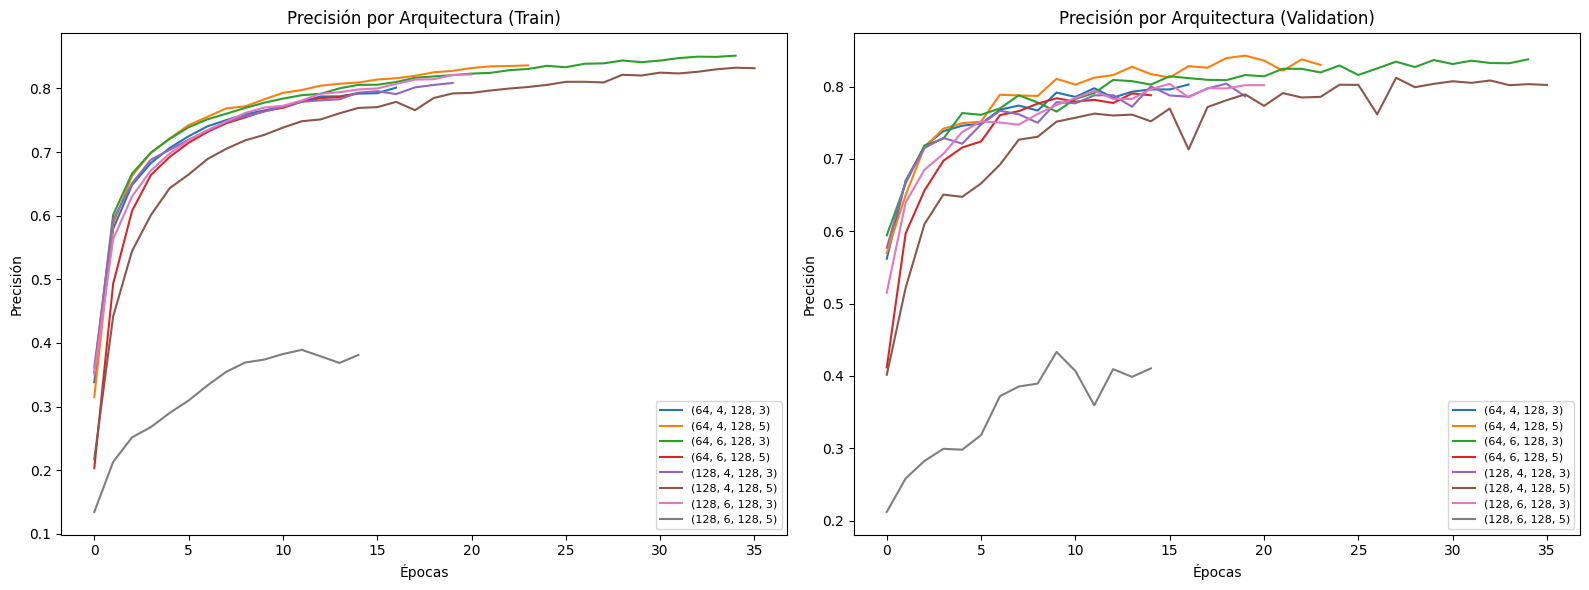

(64, 4, 128, 3) - Tiempo total de entrenamiento: 239.09 segundos
(64, 4, 128, 5) - Tiempo total de entrenamiento: 438.26 segundos
(64, 6, 128, 3) - Tiempo total de entrenamiento: 623.23 segundos
(64, 6, 128, 5) - Tiempo total de entrenamiento: 359.00 segundos
(128, 4, 128, 3) - Tiempo total de entrenamiento: 377.89 segundos
(128, 4, 128, 5) - Tiempo total de entrenamiento: 1220.88 segundos
(128, 6, 128, 3) - Tiempo total de entrenamiento: 487.08 segundos
(128, 6, 128, 5) - Tiempo total de entrenamiento: 621.12 segundos


In [ ]:
exp_transf.training_plot(True)
exp_transf.exec_time()

In [ ]:
exp_transf.model_summary()

MODELO: (64, 4, 128, 3)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 64, 64)              │           1,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 825,890 (3.15 MB)

 Trainable params: 275,295 (1.05 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 550,592 (2.10 MB)

___________________________________________________________________________________________________
MODELO: (64, 4, 128, 5)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)           │ (None, 64, 64)              │           1,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_6                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_7                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_8                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_10                 │ (None, 64, 64)              │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,325,090 (5.05 MB)

 Trainable params: 441,695 (1.68 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 883,392 (3.37 MB)

___________________________________________________________________________________________________
MODELO: (64, 6, 128, 3)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)           │ (None, 64, 64)              │           1,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_11                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_12                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_13                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,124,258 (4.29 MB)

 Trainable params: 374,751 (1.43 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 749,504 (2.86 MB)

___________________________________________________________________________________________________
MODELO: (64, 6, 128, 5)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)           │ (None, 64, 64)              │           1,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_14                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_15                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_16                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_17                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_18                 │ (None, 64, 64)              │         116,352 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,822,370 (6.95 MB)

 Trainable params: 607,455 (2.32 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,214,912 (4.63 MB)

___________________________________________________________________________________________________
MODELO: (128, 4, 128, 3)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_30 (Sequential)           │ (None, 64, 128)             │           2,179 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_19                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_20                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_21                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,805,602 (10.70 MB)

 Trainable params: 935,199 (3.57 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 1,870,400 (7.14 MB)

___________________________________________________________________________________________________
MODELO: (128, 4, 128, 5)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_35 (Sequential)           │ (None, 64, 128)             │           2,179 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_22                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_23                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_24                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_25                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_26                 │ (None, 64, 128)             │         297,344 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,589,666 (17.51 MB)

 Trainable params: 1,529,887 (5.84 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,059,776 (11.67 MB)

___________________________________________________________________________________________________
MODELO: (128, 6, 128, 3)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_42 (Sequential)           │ (None, 64, 128)             │           2,179 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_27                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_28                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_29                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,992,162 (15.23 MB)

 Trainable params: 1,330,719 (5.08 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 2,661,440 (10.15 MB)

___________________________________________________________________________________________________
MODELO: (128, 6, 128, 5)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_47 (Sequential)           │ (None, 64, 128)             │           2,179 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_30                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_31                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_32                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_33                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_34                 │ (None, 64, 128)             │         429,184 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 31)                  │           7,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,567,266 (25.05 MB)

 Trainable params: 2,189,087 (8.35 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 4,378,176 (16.70 MB)

___________________________________________________________________________________________________


In [ ]:
exp_transf.table_results()

,"(64, 4, 128, 3)","(64, 4, 128, 5)","(64, 6, 128, 3)","(64, 6, 128, 5)","(128, 4, 128, 3)","(128, 4, 128, 5)","(128, 6, 128, 3)","(128, 6, 128, 5)"
train,0.801089,0.836159,0.851416,0.792631,0.808544,0.831718,0.821753,0.381271
val,0.802908,0.829981,0.837717,0.788057,0.786510,0.802290,0.801980,0.410427


102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 237ms/step - accuracy: 0.8415 - loss: 0.7330
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


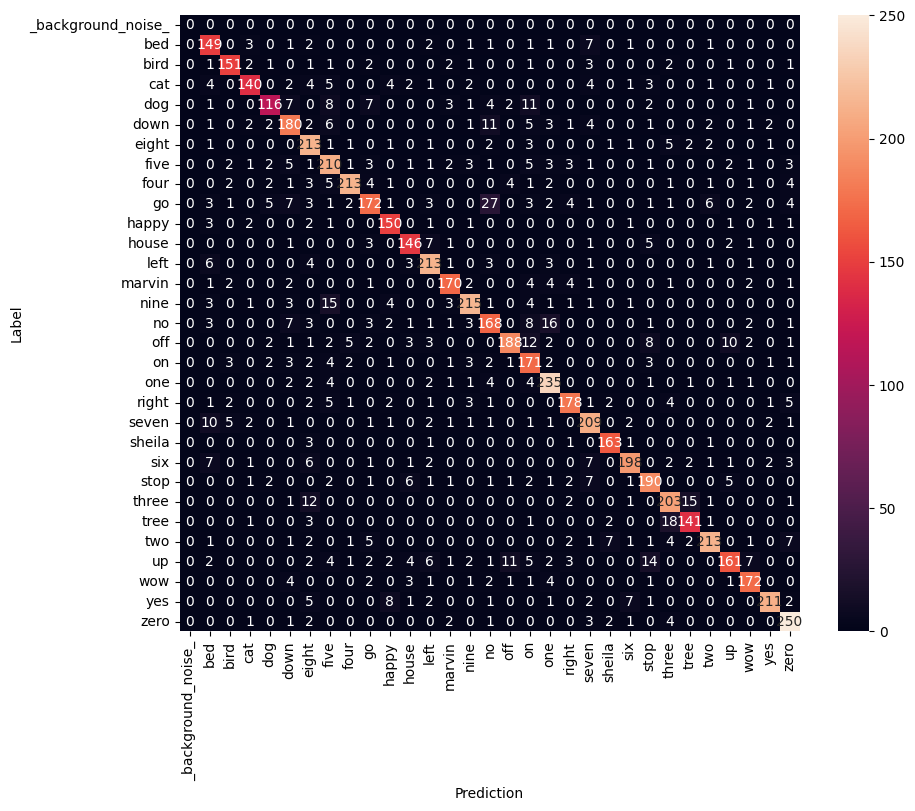

In [ ]:
best_transf_model = exp_transf.results[(64, 6, 128, 3)]['model']
exp_transf.test_inference(best_transf_model, test_spectrogram_ds, label_names)

In [ ]:
exp_transf.save_submission('submission_transf.csv')

# Canvi d'entrades

In [ ]:
class Experiment_Inputs(Experiment_Models):
    def run_exp(self, build_model, model_arch):
        for exp in self.exp:
            train_spectrogram_ds, val_spectrogram_ds, self.test_spectrogram_ds = get_datasets(train_ds, val_ds, test_ds, exp)
            global input_shape
            input_shape = tuple(train_spectrogram_ds.element_spec[0].shape)[1:]
            model = build_model(model_arch)
            train_spectrogram_ds, val_spectrogram_ds, self.test_spectrogram_ds = to_cache(train_spectrogram_ds, val_spectrogram_ds, self.test_spectrogram_ds)
            self.results[exp] = self._run_model(model, train_spectrogram_ds, val_spectrogram_ds)

    def test_inference(self, model, label_names):
        model.evaluate(self.test_spectrogram_ds, return_dict=True)
        self.y_pred = model.predict(self.test_spectrogram_ds)
        self.y_pred = tf.argmax(self.y_pred, axis=1)
        y_true = tf.concat(list(self.test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
        confusion_mtx = tf.math.confusion_matrix(y_true, self.y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx,
                    xticklabels=label_names,
                    yticklabels=label_names,
                    annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.show()

In [ ]:
def get_spectrogram(waveform, spectrogram_type="linear", target_length=16000, frame_length=255, frame_step=128,
                    num_mel_bins=129, num_mfccs=13, use_db=False):
    """
    Convierte una forma de onda en un espectrograma del tipo especificado: Lineal, MEL o MFCC.
    """
    # Asegurar longitud de la forma de onda
    waveform = tf.cast(waveform, tf.float32)
    """
    waveform = tf.cond(
        tf.shape(waveform)[0] < target_length,
        lambda: tf.pad(waveform, [[0, target_length - tf.shape(waveform)[0]]], mode='CONSTANT'),
        lambda: waveform[:target_length]
    )
    """
    # Calcular STFT y tomar magnitud
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    if spectrogram_type == "linear":
        # Escala logarítmica opcional
        if use_db:
            spectrogram = tf.math.log(spectrogram + 1e-6)
        return spectrogram[..., tf.newaxis]

    elif spectrogram_type in ["mel", "mfcc"]:
        # Convertir a espectrograma MEL
        # Ensure num_spectrogram_bins matches the STFT output
        num_spectrogram_bins = spectrogram.shape[-1]
        linear_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=num_mel_bins,
            num_spectrogram_bins=num_spectrogram_bins, # Changed this line
            sample_rate=16000
        )
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_matrix, axes=1)
        if use_db:
            mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

        if spectrogram_type == "mel":
            return mel_spectrogram[..., tf.newaxis]

        elif spectrogram_type == "mfcc":
            # Convertir a MFCC
            mfccs = tf.signal.mfccs_from_log_mel_spectrograms(mel_spectrogram)[..., :num_mfccs]
            return mfccs[..., tf.newaxis]

    else:
        raise ValueError(f"Tipo de espectrograma no soportado: {spectrogram_type}")

def make_spec_ds(ds, spectrogram_type="linear", target_length=16000, frame_length=256, frame_step=128,
                    num_mel_bins=129, num_mfccs=13, use_db=False):
    """
    Aplica la función de generación de espectrogramas a un dataset.
    """
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio, spectrogram_type, target_length, frame_length,
                    frame_step, num_mel_bins, num_mfccs, use_db), label), num_parallel_calls=tf.data.AUTOTUNE
    )

def get_datasets(train, val, test, setup):
    """
    Crea datasets de entrenamiento, validación y prueba con espectrogramas.
    """
    setup = setup.split('-')
    spectrogram_type, target_length, frame_length, frame_step, num_mel_bins, num_mfccs, use_db = \
        setup[0], int(setup[1]), int(setup[2]), int(setup[3]), int(setup[4]), int(setup[5]), setup[6] == 'dB'
    train_spectrogram_ds = make_spec_ds(train, spectrogram_type, target_length, frame_length,
                    frame_step, num_mel_bins, num_mfccs, use_db)
    val_spectrogram_ds = make_spec_ds(val, spectrogram_type, target_length, frame_length,
                    frame_step, num_mel_bins, num_mfccs, use_db)
    test_spectrogram_ds = make_spec_ds(test, spectrogram_type, target_length, frame_length,
                    frame_step, num_mel_bins, num_mfccs, use_db)
    return train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds

def to_cache(train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds):
    train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
    return train_spectrogram_ds, val_spectrogram_ds, test_spectrogram_ds

## Linear Spectrogram

### Frame-length i Frame-step

In [ ]:
l = ['linear-16000-255-60-0-0-NOdB','linear-16000-255-128-0-0-NOdB', 'linear-16000-512-60-0-0-NOdB', 'linear-16000-1024-30-0-0-NOdB']
for z in l:
    x = get_datasets(train_ds, val_ds, test_ds, z)
    i = tuple(x[0].element_spec[0].shape)[1:]
    print(z, i)

linear-16000-255-60-0-0-NOdB (263, 129, 1)
linear-16000-255-128-0-0-NOdB (124, 129, 1)
linear-16000-512-60-0-0-NOdB (259, 257, 1)
linear-16000-1024-30-0-0-NOdB (500, 513, 1)


In [ ]:
exp_linear_spect_f = Experiment_Inputs(['linear-16000-255-128-0-0-NOdB', 'linear-16000-512-60-0-0-NOdB', 'linear-16000-1024-30-0-0-NOdB'], EPOCHS)
exp_linear_spect_f.run_exp(build_model_conv, 'advanced')

In [ ]:
exp_linear_spect_f.training_plot(False)

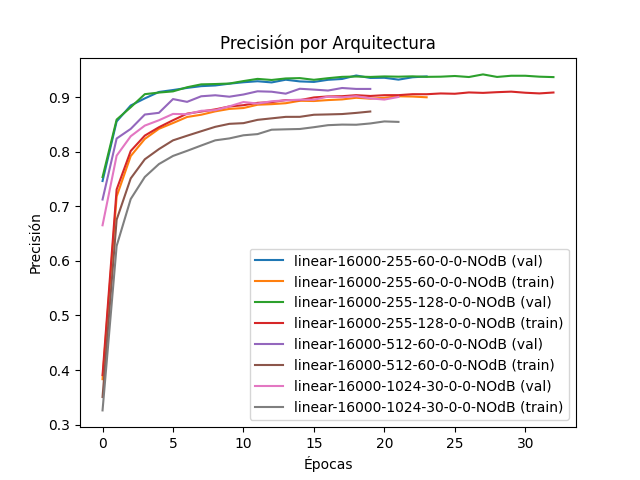

In [ ]:
exp_linear_spect_f.exec_time()
exp_linear_spect_f.table_results()

,linear-16000-255-60-0-0-NOdB,linear-16000-255-128-0-0-NOdB,linear-16000-512-60-0-0-NOdB,linear-16000-1024-30-0-0-NOdB
train,0.899618,0.908366,0.873547,0.854544
val,0.937809,0.936572,0.914913,0.900217


### L'ús de dB

In [ ]:
exp_linear_spect = Experiment_Inputs(['linear-16000-255-128-0-0-NOdB', 'linear-16000-255-128-0-0-dB'], EPOCHS)

In [ ]:
exp_linear_spect.run_exp(build_model_conv, 'advanced')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


810/810 ━━━━━━━━━━━━━━━━━━━━ 98s 39ms/step - accuracy: 0.2206 - loss: 2.7295 - val_accuracy: 0.7864 - val_loss: 0.7188
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7017 - loss: 0.9914 - val_accuracy: 0.8569 - val_loss: 0.4771
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7864 - loss: 0.7156 - val_accuracy: 0.8832 - val_loss: 0.3914
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8234 - loss: 0.6032 - val_accuracy: 0.8943 - val_loss: 0.3516
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8410 - loss: 0.5300 - val_accuracy: 0.9047 - val_loss: 0.3221
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8551 - loss: 0.4936 - val_accuracy: 0.9117 - val_loss: 0.2999
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8654 - loss: 0.4529 - val_accuracy: 0.9148 - val_loss: 0.2829
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8731 - loss: 0.4346 - val_accuracy: 0.9169 - 

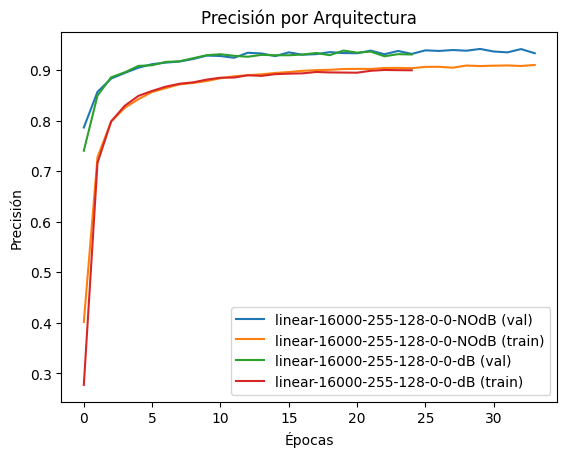

linear-16000-255-128-0-0-NOdB - Tiempo total de entrenamiento: 358.30 segundos
linear-16000-255-128-0-0-dB - Tiempo total de entrenamiento: 247.83 segundos


,linear-16000-255-128-0-0-NOdB,linear-16000-255-128-0-0-dB
train,0.910027,0.899598
val,0.933323,0.930848


In [ ]:
exp_linear_spect.training_plot(False)
exp_linear_spect.exec_time()
exp_linear_spect.table_results()

## Mel Spectrogram

In [ ]:
exp_mel_spect = Experiment_Inputs(['mel-16000-255-128-80-0-NOdB', 'mel-16000-255-128-129-0-NOdB', 'mel-16000-255-128-256-0-NOdB'], EPOCHS)
exp_mel_spect.run_exp(build_model_conv, 'advanced')

In [ ]:
exp_mel_spect.training_plot(False)

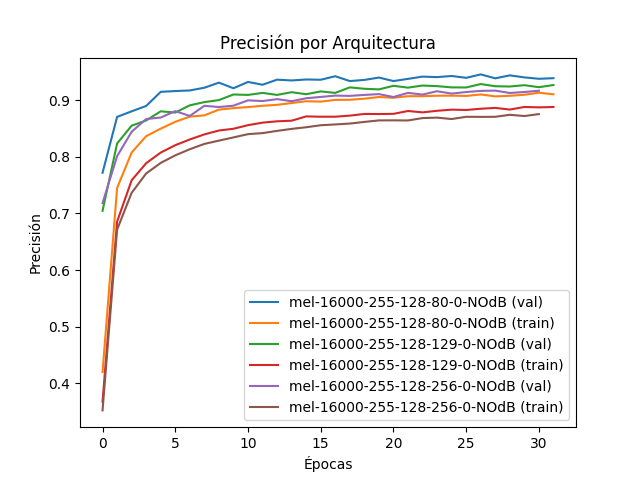

In [ ]:
exp_mel_spect.exec_time()
exp_mel_spect.table_results()

mel-16000-255-128-80-0-NOdB - Tiempo total de entrenamiento: 91.36 segundos
mel-16000-255-128-129-0-NOdB - Tiempo total de entrenamiento: 76.41 segundos
mel-16000-255-128-256-0-NOdB - Tiempo total de entrenamiento: 96.00 segundos


,mel-16000-255-128-80-0-NOdB,mel-16000-255-128-129-0-NOdB,mel-16000-255-128-256-0-NOdB
train,0.910297,0.887837,0.875362
val,0.938738,0.926671,0.916615


## MFCC

In [ ]:
exp_mfcc_spect = Experiment_Inputs(['mfcc-16000-255-128-80-13-NOdB', 'mfcc-16000-255-128-80-19-NOdB', 'mfcc-16000-255-128-80-26-NOdB'], EPOCHS)

In [ ]:
exp_mfcc_spect.run_exp(build_model_conv, 'advanced')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


810/810 ━━━━━━━━━━━━━━━━━━━━ 89s 22ms/step - accuracy: 0.1609 - loss: 2.9099 - val_accuracy: 0.6699 - val_loss: 1.1374
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6054 - loss: 1.3429 - val_accuracy: 0.8026 - val_loss: 0.6654
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7189 - loss: 0.9451 - val_accuracy: 0.8422 - val_loss: 0.5251
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7694 - loss: 0.7795 - val_accuracy: 0.8563 - val_loss: 0.4767
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7980 - loss: 0.6926 - val_accuracy: 0.8759 - val_loss: 0.4099
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8118 - loss: 0.6402 - val_accuracy: 0.8864 - val_loss: 0.3745
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8251 - loss: 0.5966 - val_accuracy: 0.8883 - val_loss: 0.3654
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8293 - loss: 0.5758 - val_accuracy: 0.8895 

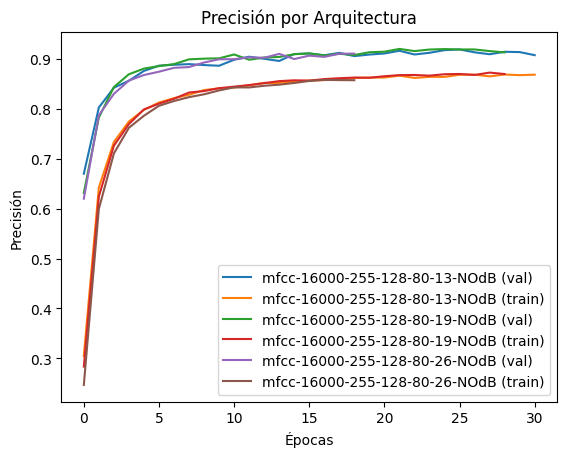

mfcc-16000-255-128-80-13-NOdB - Tiempo total de entrenamiento: 342.22 segundos
mfcc-16000-255-128-80-19-NOdB - Tiempo total de entrenamiento: 329.01 segundos
mfcc-16000-255-128-80-26-NOdB - Tiempo total de entrenamiento: 229.32 segundos


,mfcc-16000-255-128-80-13-NOdB,mfcc-16000-255-128-80-19-NOdB,mfcc-16000-255-128-80-26-NOdB
train,0.868371,0.869684,0.857325
val,0.907488,0.913057,0.910582


In [ ]:
exp_mfcc_spect.training_plot(False)
exp_mfcc_spect.exec_time()
exp_mfcc_spect.table_results()

## Best input test inference

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9371 - loss: 0.2016
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


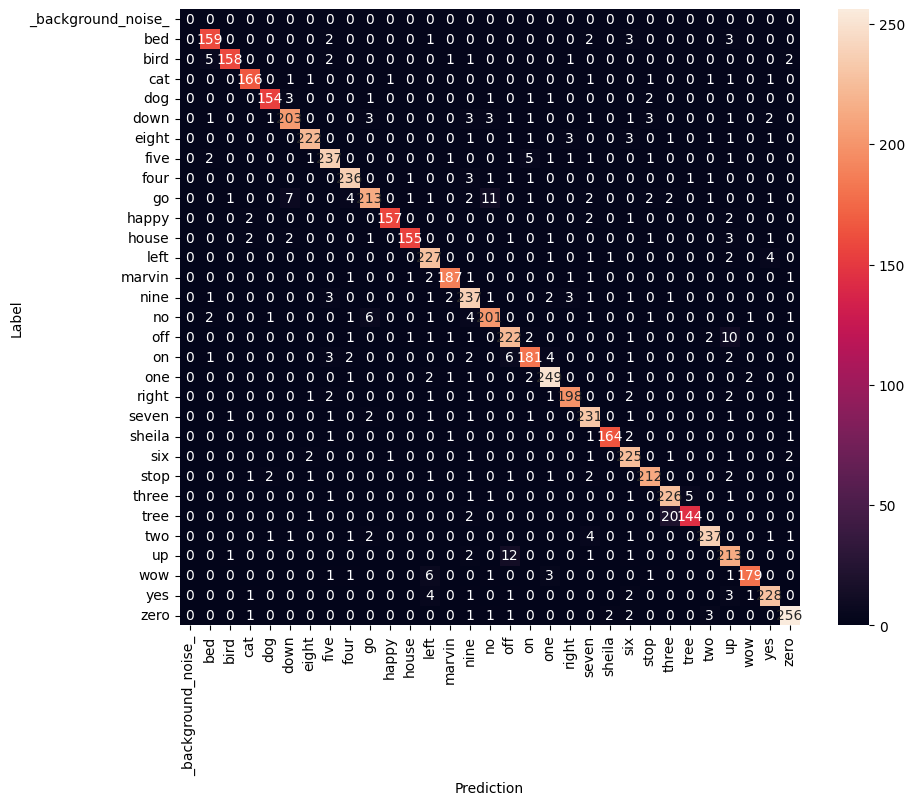

In [ ]:
best_input_model = exp_mel_spect.results['mel-16000-255-128-80-0-NOdB']['model']
exp_mel_spect.test_inference(best_input_model, label_names)

In [ ]:
exp_mel_spect.save_submission('submission_input.csv')

# Últimes Millores

## CNN profund

In [ ]:
EPOCHS = 100
num_labels = len(label_names)

In [ ]:
def build_model_conv(architecture='complex'):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Downsampling the input
        layers.Resizing(64, 64),  # Aumentamos el tamaño para aprovechar mayor resolución

        # Normalization
        layers.Normalization(),

        # Bloque Conv1
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),

        # Bloque Conv2
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.4),

        # Bloque Conv3
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),

        # Bloque Conv4 (Adicional)
        layers.Conv2D(512, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),

        # Flatten y capas densas
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reducir learning rate
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Quita `from_logits`
        metrics=['accuracy'],
    )
    return model

In [ ]:
exp_final = Experiment_Inputs(['mel-16000-255-128-80-0-NOdB'], EPOCHS)
exp_final.run_exp(build_model_conv, 'UwU')

Epoch 1/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 142s 106ms/step - accuracy: 0.0382 - loss: 4.0292 - val_accuracy: 0.0600 - val_loss: 3.3217
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.0631 - loss: 3.3234 - val_accuracy: 0.2194 - val_loss: 2.7844
Epoch 3/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.1265 - loss: 3.0128 - val_accuracy: 0.3962 - val_loss: 2.1027
Epoch 4/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.2697 - loss: 2.4559 - val_accuracy: 0.6570 - val_loss: 1.1842
Epoch 5/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - accuracy: 0.4734 - loss: 1.7437 - val_accuracy: 0.7984 - val_loss: 0.7006
Epoch 6/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.6572 - loss: 1.1600 - val_accuracy: 0.8855 - val_loss: 0.4011
Epoch 7/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.7597 - loss: 0.8302 - val_accuracy: 0.8877 - val_loss: 0.4037
Epoch 8/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.8156 - loss:

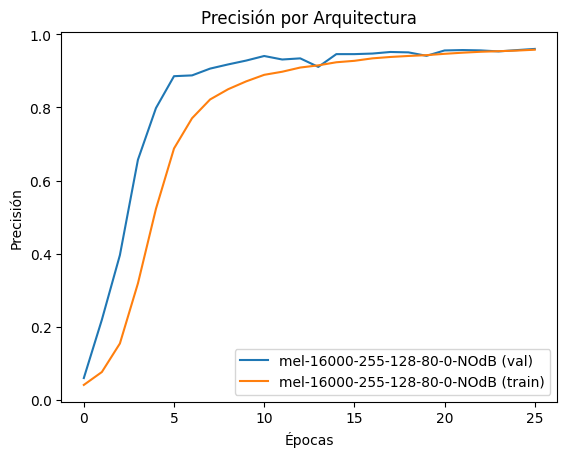

In [ ]:
exp_final.training_plot(False)

In [ ]:
exp_final.model_summary()

MODELO: mel-16000-255-128-80-0-NOdB


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,070,370 (103.27 MB)

 Trainable params: 9,022,175 (34.42 MB)

 Non-trainable params: 3,843 (15.02 KB)

 Optimizer params: 18,044,352 (68.83 MB)

___________________________________________________________________________________________________


In [ ]:
exp_final.exec_time()
exp_final.table_results()

mel-16000-255-128-80-0-NOdB - Tiempo total de entrenamiento: 1868.81 segundos


,mel-16000-255-128-80-0-NOdB
train,0.957939
val,0.960087


102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.9609 - loss: 0.1786
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


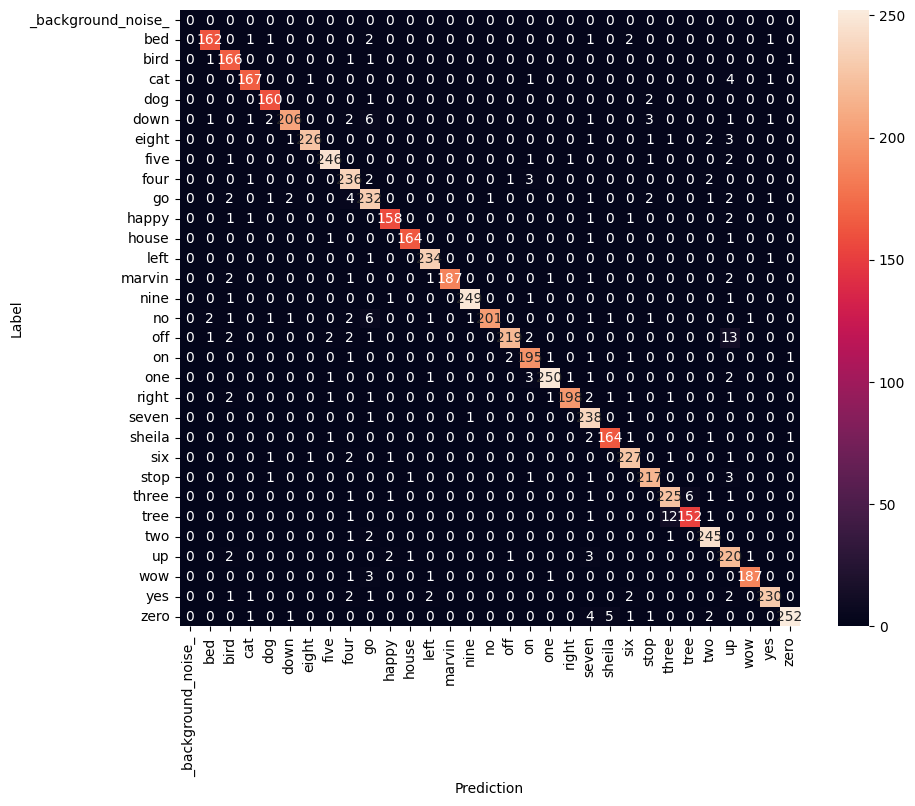

In [ ]:
exp_final.test_inference(exp_final.results['mel-16000-255-128-80-0-NOdB']['model'], label_names)

In [ ]:
exp_final.save_submission('submission_UwU.csv')

## CNN + RNN

In [ ]:
# Función para construir diferentes arquitecturas
def build_model_rnn_conv(architecture='residual_deep'):
    inputs = layers.Input(shape=input_shape)
    # **Sección Convolucional Profunda**
    x = layers.Resizing(128, 128)(inputs)  # Redimensionar a 128x128
    x = layers.Normalization()(x)  # Normalización inicial

    # Bloque CNN 1
    for filters in [64, 128]:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

    # Bloque CNN 2
    for filters in [256, 256]:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

    # Bloque CNN 3
    for filters in [512]:
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.4)(x)

    # Aplanar y preparar para la RNN
    x = layers.Reshape((-1, x.shape[-1]))(x)  # Convertir dimensiones para la RNN

    # **Sección GRU Profunda**
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.4))(x)
    x = layers.Bidirectional(layers.GRU(512, return_sequences=True, dropout=0.4))(x)
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False, dropout=0.2))(x)

    # **Capas Densas Finales**
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    # **Salida**
    outputs = layers.Dense(num_labels, activation='softmax')(x)

    # Crear el modelo
    model = models.Model(inputs, outputs)

    # Compilación
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),  # Tasa de aprendizaje más baja
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [ ]:
exp_final = Experiment_Inputs(['mel-16000-255-128-80-0-NOdB'], EPOCHS)
exp_final.run_exp(build_model_rnn_conv, 'T_T')

In [ ]:
exp_final.training_plot(False)

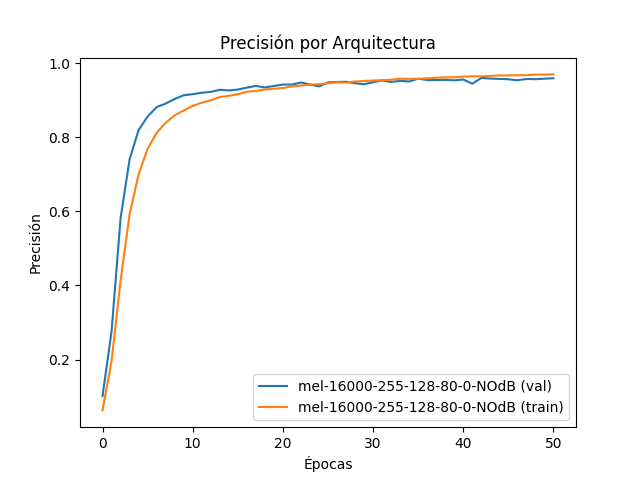

In [4]:
exp_final.model_summary()

MODELO: mel-16000-255-128-80-0-NOdB 
Model: model 
_________________________________________________________________ 
 Layer (type)                Output Shape              Param #    
 input_1 (InputLayer)        [(None, 124, 80, 1)]      0          
                                                                  
 resizing (Resizing)         (None, 128, 128, 1)       0          
                                                                  
 normalization (Normalizati  (None, 128, 128, 1)       3          
 on)                                                              
                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)      640        
                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)      256        
 Normalization)                                                   
                                                                  
 max_poolin

In [12]:
exp_final.exec_time()
exp_final.table_results()

mel-16000-255-128-80-0-NOdB - Tiempo total de entrenamiento: 1488.10 segundos


,mel-16000-255-128-80-0-NOdB
train,0.969777
val,0.959313


In [3]:
exp_final.test_inference(exp_final.results['mel-16000-255-128-80-0-NOdB']['model'], label_names)

102/102 [==============================] - 2s 15ms/step - loss: 0.1836 - accuracy: 0.9603


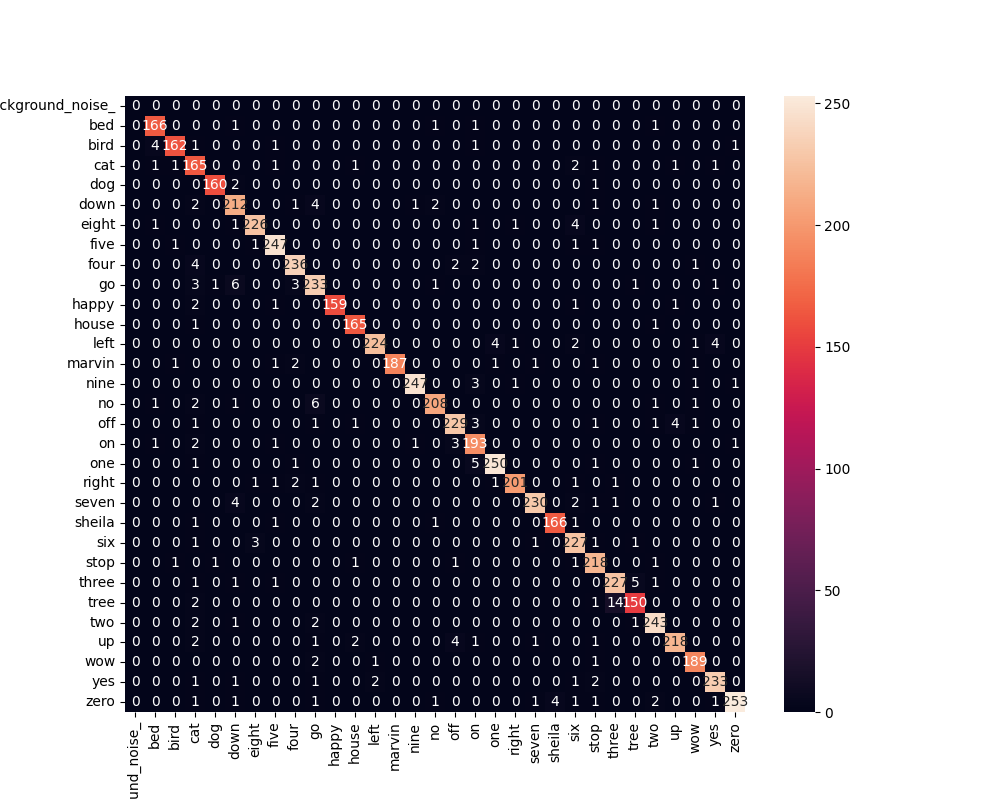

In [ ]:
exp_final.save_submission('submission_T_T.csv')

## Data Augmentation

In [ ]:
def time_shift(spectrogram, max_shift):
    """
    Realiza un desplazamiento aleatorio en el tiempo.
    """
    shift = np.random.randint(-max_shift, max_shift)
    return tf.roll(spectrogram, shift, axis=1)

def time_mask(spectrogram, max_width):
    """
    Enmascarado aleatorio en el tiempo.
    """
    time_max = tf.shape(spectrogram)[1]  # Get the time dimension (axis 1)
    t = tf.random.uniform([], minval=0, maxval=max_width, dtype=tf.int32)
    t0 = tf.random.uniform([], minval=0, maxval=time_max - t, dtype=tf.int32)
    mask = tf.concat([
        tf.ones((t0,), dtype=spectrogram.dtype),
        tf.zeros((t,), dtype=spectrogram.dtype),
        tf.ones((time_max - t0 - t,), dtype=spectrogram.dtype)
    ], 0)
    # Expand the mask to match the spectrogram shape
    mask = tf.expand_dims(tf.expand_dims(mask, axis=0), axis=-1)
    return spectrogram * mask  # Apply the mask

def frequency_mask(spectrogram, max_width):
    """
    Enmascarado aleatorio en las frecuencias del espectrograma.
    """
    freq_max = tf.shape(spectrogram)[0]
    f = tf.random.uniform([], minval=0, maxval=max_width, dtype=tf.int32)
    f0 = tf.random.uniform([], minval=0, maxval=freq_max - f, dtype=tf.int32)
    mask = tf.concat([
        tf.ones((f0,), dtype=spectrogram.dtype),
        tf.zeros((f,), dtype=spectrogram.dtype),
        tf.ones((freq_max - f0 - f,), dtype=spectrogram.dtype)
    ], 0)
    # Expand the mask to match the spectrogram shape
    mask = tf.expand_dims(tf.expand_dims(mask, axis=-1), axis=1)
    return spectrogram * mask  # Apply the mask

def spec_augment(spectrogram, freq_mask_width, time_mask_width):
    """
    Realiza el enmascarado de frecuencia y tiempo (SpecAugment).
    """
    spectrogram = frequency_mask(spectrogram, freq_mask_width)
    spectrogram = time_mask(spectrogram, time_mask_width)
    return spectrogram

def get_spectrogram(waveform, spectrogram_type="linear", target_length=16000, frame_length=255, frame_step=128,
                    num_mel_bins=129, num_mfccs=13, use_db=False):
    """
    Convierte una forma de onda en un espectrograma del tipo especificado: Lineal, MEL o MFCC.
    Aplica técnicas de data augmentation si se especifica.
    """
    # Asegurar longitud de la forma de onda
    waveform = tf.cast(waveform, tf.float32)

    # Calcular STFT y tomar magnitud
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    if True:
        # Aplicar augmentación si se indica
        spectrogram = spec_augment(spectrogram, freq_mask_width=5, time_mask_width=10)
        spectrogram = time_shift(spectrogram, max_shift=10)

    if spectrogram_type == "linear":
        # Escala logarítmica opcional
        if use_db:
            spectrogram = tf.math.log(spectrogram + 1e-6)
        return spectrogram[..., tf.newaxis]

    elif spectrogram_type in ["mel", "mfcc"]:
        # Convertir a espectrograma MEL
        num_spectrogram_bins = spectrogram.shape[-1]
        linear_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=num_mel_bins,
            num_spectrogram_bins=num_spectrogram_bins, # Cambiado para coincidir con el STFT
            sample_rate=16000
        )
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_matrix, axes=1)
        if use_db:
            mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

        if spectrogram_type == "mel":
            return mel_spectrogram[..., tf.newaxis]

        elif spectrogram_type == "mfcc":
            # Convertir a MFCC
            mfccs = tf.signal.mfccs_from_log_mel_spectrograms(mel_spectrogram)[..., :num_mfccs]
            return mfccs[..., tf.newaxis]

    else:
        raise ValueError(f"Tipo de espectrograma no soportado: {spectrogram_type}")

In [ ]:
exp_final = Experiment_Inputs(['mel-16000-255-128-80-0-NOdB'], EPOCHS)
exp_final.run_exp(build_model_conv, 'OwO')

In [ ]:
exp_final.training_plot(False)

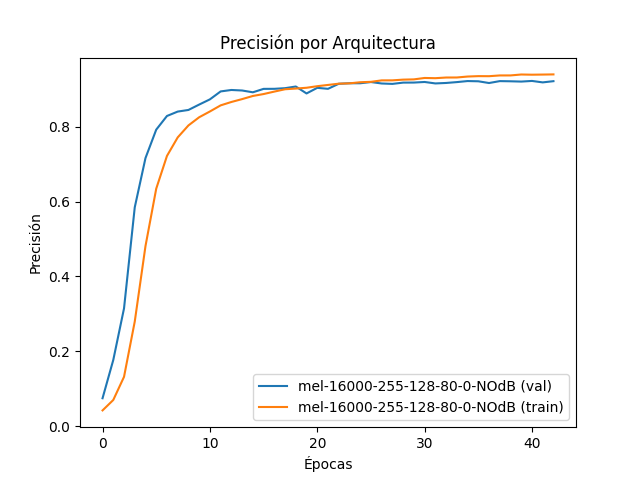

In [ ]:
exp_final.table_results()

,mel-16000-255-128-80-0-NOdB
train,0.939651
val,0.921566
